# Numerical Optimization

In [12]:
#Load Packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from scipy import linalg
from IPython.display import display, clear_output
import time

#Define function plotting function
fys = []


def plot_function(xdims, ydims, f, title):
    global fys

    #Prepare grid for plotting decision surface
    gx1, gx2 = np.meshgrid(
        np.arange(xdims[0], xdims[1], (xdims[1] - xdims[0]) / 100.0),
        np.arange(ydims[0], ydims[1], (ydims[1] - ydims[0]) / 100.0)
    )
    gx1l = gx1.flatten()
    gx2l = gx2.flatten()
    gx = np.vstack((gx1l, gx2l)).T

    #Compute a prediction for every point in the grid
    #Cache for fast redisplay
    if (len(fys) == 0):
        y = f(gx)
        y = np.reshape(y, gx1.shape)
        fys = y
    else:
        y = fys

    #Plot a contour map of the function
    plt.contourf(gx1, gx2, y,
                 levels=np.unique(np.round(np.linspace(0, (np.max(y)), 10))))
    plt.colorbar()
    plt.contour(gx1, gx2, y, colors='k',
                levels=np.unique(np.round(np.linspace(0, (np.max(y)), 10))))

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(False)
    plt.title(title)


def plot_step(x, xprime):
    plt.plot([x[0], xprime[0]], [x[1], xprime[1]], '.-w')


def plot_all_steps(xs):
    for i in range(xs.shape[0] - 1):
        plot_step(xs[i, :], xs[i + 1, :])


def optimiziation_plot(x, f, i):
    clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plot_function([-10, 10], [-10, 10], q.f, "Objective Function (%d)" % (i))
    plot_all_steps(x)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)

    plt.subplot(1, 2, 2)
    plt.plot(f[:i], 'k-')
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function')
    plt.title("Objective vs Iteration (%d)" % (i))

    plt.show()


Create a Function
===

In [13]:
class quad_func():
    def __init__(self, A, b, c):
        self.A = A
        self.b = b
        self.c = c
        self.fcount = 0
        self.gcount = 0

    def f(self, x):
        self.fcount += 1
        if (len(x.shape) == 1):
            fx = x.T.dot(self.A).dot(x) + x.dot(self.b.T) + self.c
            return fx[0]
        else:
            return np.sum(x.dot(self.A) * x, axis=1, keepdims=True) + x.dot(self.b.T) + self.c

    def g(self, x):
        self.gcount += 1
        return 2 * np.reshape(x.dot(self.A) + self.b, x.shape)

    def reset_counts(self):
        self.fcount = 0
        self.gcount = 0


def data_selector():
    #Define the event handler
    def onclick(event):
        x = event.xdata
        y = event.ydata
        x = np.array([x, y])
        d = -q.g(x)
        plt.plot(x[0], x[1], 'wo')
        plt.arrow(x[0], x[1], d[0], d[1], color='w', head_length=0.5, head_width=0.5);

    #Create a callback to connect the handler to mouse click events 
    cid = fig.canvas.mpl_connect('button_press_event', onclick)


Gradient Explorer
--

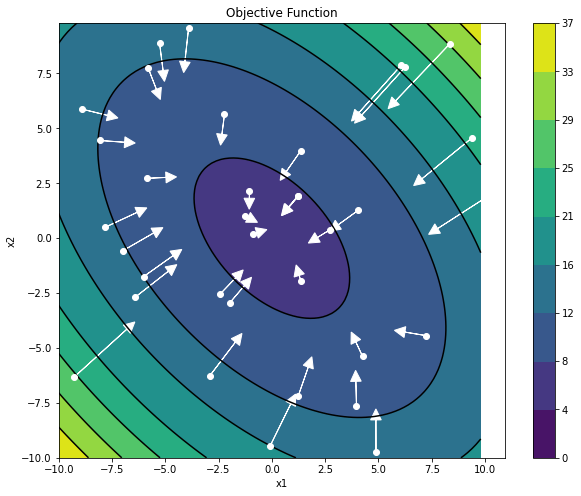

In [42]:
%matplotlib inline

q = quad_func(np.array([[0.1, 0.05], [0.05, 0.1]]), np.array([[0, 0]]), 7)
fig = plt.figure(figsize=(10, 8))
plot_function([-10, 10], [-10, 10], q.f, "Objective Function")

# Generate some random points on the 2D plane.
rng = np.random.default_rng()
x = np.vstack(
    (
        rng.uniform(low=-10, high=10, size=(30, 2)),
        # create some more points for the center of the plot.
        rng.uniform(low=-2, high=2, size=(5, 2))
    )
)


d = -q.g(x)

plt.plot(x[:, 0], x[:, 1], 'wo')

for row_index in range(x.shape[0]):
    arrow_start = x[row_index, :]
    arrow_end = d[row_index, :]
    plt.arrow(
        arrow_start[0], arrow_start[1],
        arrow_end[0], arrow_end[1],
        color='w', head_length=0.5, head_width=0.5
    )

# Steepest Descent with Fixed Step Size

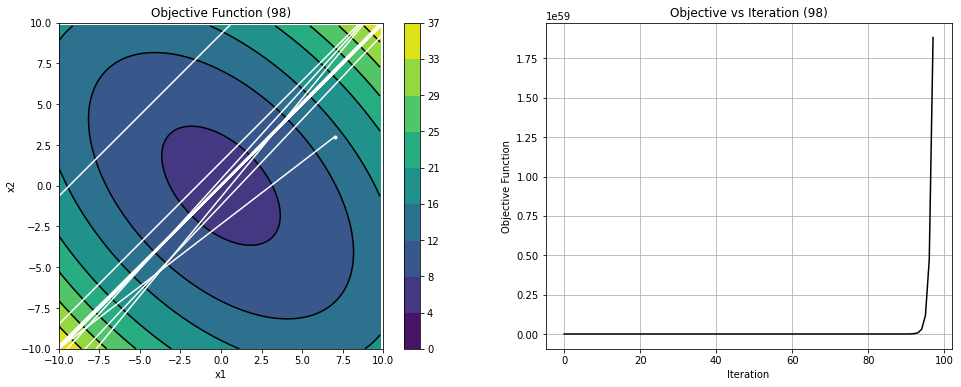

Number of function evals: 100
Number of gradient evals: 100


In [15]:
%matplotlib inline
q.reset_counts()
x = np.zeros((100, 2))
f = np.zeros((100,))
x[0, :] = np.array([7, 3])
f[0] = q.f(x[0, :])
alpha = 10
tol = 1e-4
maxIter = 100
try:
    for i in range(maxIter):
        x[i + 1, :] = x[i, :] + alpha * (-1 * q.g(x[i, :]))
        f[i + 1] = q.f(x[i + 1, :])
        optimiziation_plot(x[:i + 2, :], f[:i + 2], i)
        if abs(f[i + 1] - f[i]) / abs(f[i + 1]) < tol: break
except:
    pass

print("Number of function evals: %d" % (q.fcount))
print("Number of gradient evals: %d" % (q.gcount))

# Steepest Descent with Backtracking Line Search

In [16]:
q.reset_counts()
x = np.zeros((100, 2))
f = np.zeros((100,))
x[0, :] = np.array([7, 3])
f[0] = q.f(x[0, :])
alpha0 = 10
rho = 0.9
tol = 1e-4
maxIter = 100

try:
    for i in range(maxIter):
        alpha = alpha0
        d = -q.g(x[i, :])
        for j in range(100):
            x[i + 1, :] = x[i, :] + alpha * d
            f[i + 1] = q.f(x[i + 1, :])
            optimiziation_plot(x[:i + 2, :], f[:i + 2], i)
            if (f[i + 1] > f[i]):
                alpha = alpha * rho
            else:
                break
        if abs(f[i + 1] - f[i]) / abs(f[i + 1]) < tol: break
except:
    pass

print("Number of function evals: %d" % (q.fcount))
print("Number of gradient evals: %d" % (q.gcount))

Number of function evals: 161
Number of gradient evals: 32


# Steepest Descent with Backtracking Line Search and Armijo Rule

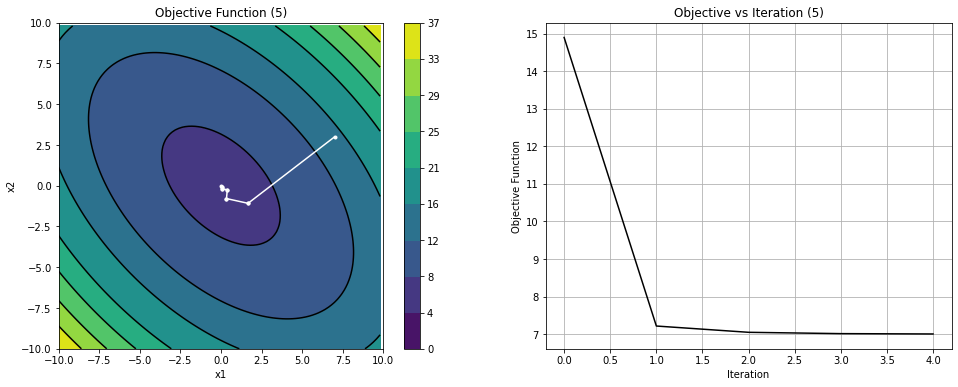

Number of function evals: 48
Number of gradient evals: 6


In [17]:
q.reset_counts()
x = np.zeros((100, 2))
f = np.zeros((100,))
x[0, :] = np.array([7, 3])
f[0] = q.f(x[0, :])
alpha0 = 10
rho = 0.9
tol = 1e-4
c = 0.5
maxIter = 100

try:
    for i in range(maxIter):
        alpha = alpha0
        g = q.g(x[i, :])
        d = -g
        for j in range(100):
            x[i + 1, :] = x[i, :] + alpha * d
            f[i + 1] = q.f(x[i + 1, :])
            optimiziation_plot(x[:i + 2, :], f[:i + 2], i)
            if f[i + 1] > f[i] + alpha * c * d.dot(g):
                alpha = alpha * rho
            else:
                break
        if abs(f[i + 1] - f[i]) / abs(f[i + 1]) < tol: break
except:
    pass

print("Number of function evals: %d" % (q.fcount))
print("Number of gradient evals: %d" % (q.gcount))

# L-BFGS

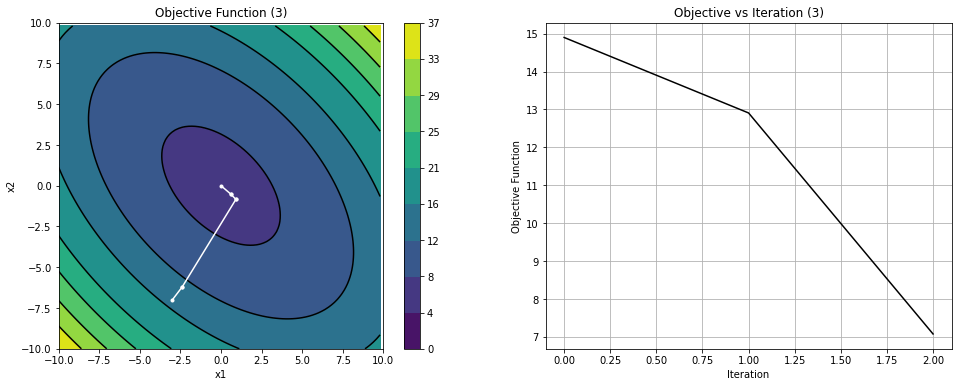

Number of function evals: 10
Number of gradient evals: 5


In [18]:
%matplotlib inline
from scipy.optimize import minimize

q.reset_counts()
x = np.zeros((100, 2))
f = np.zeros((100,))
x[0, :] = np.array([-3, -7])
f[0] = q.f(x[0, :])
maxIter = 100
i = 0


def visualize(xnew):
    global x
    global f
    global i
    x[i + 1, :] = xnew
    f[i + 1] = q.f(xnew)
    optimiziation_plot(x[:i + 2, :], f[:i + 2], i)
    i = i + 1


minimize(q.f, x[0, :], jac=q.g, method="L-BFGS-B", callback=visualize)

print("Number of function evals: %d" % (q.fcount))
print("Number of gradient evals: %d" % (q.gcount))

# Gradient  Checks

In [19]:
from scipy.optimize import approx_fprime

f = lambda x: q.f(x)
g = lambda x: q.g(x)

x = np.array((10, 10))
g_analytic = g(x)
g_approx = approx_fprime(x, f, 1e-8)

print("Analytic Gradient:            ", g_analytic)
print("Approximate Gradient:         ", g_approx)
print("Abolute Difference:           ", np.abs(g_analytic - g_approx))
print("Relative Absolute Difference: ", np.abs(g_analytic - g_approx) / np.abs(g_approx + 1e-300))

Analytic Gradient:             [3. 3.]
Approximate Gradient:          [3.00000025 3.00000025]
Abolute Difference:            [2.48221113e-07 2.48221113e-07]
Relative Absolute Difference:  [8.27403642e-08 8.27403642e-08]
